## Cel

Celem projektu jest sprawdzenie, czy można zgrupować sekwencje prokariotów ze względu 
na stosunek częstości kodonów zagrożonych mutacjami typu nonsens (powstanie zamiast
poprawnego kodonu, kodonu stop, przerywającego proces translacji materiału genetycznego
do białka) do częstości spodziewanej tych kodonów w różnych 
częściach sekwencji (początkowej, środkowej i końcowej). W tym celu stworzyłem ukryty model
Markowa, który dopasowałem do genomów:
    - Borrelia burgdorferi
    - Clostridium botulinum
    - Ehrlichia ruminantium
Cechą wspólną tych genomów jest fakt, że zawartość nukleotydów GC wynosi ok. 28%. 

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
from sklearn.cluster import DBSCAN

In [2]:
import import_ipynb
import readSequenceFunctions as rsf
import sequenceProcesing as sp

importing Jupyter notebook from readSequenceFunctions.ipynb
importing Jupyter notebook from sequenceProcesing.ipynb


In [3]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(),"..")))
import Moduly.Preprocesing as pre

importing Jupyter notebook from /media/kuba/DANE/Dokumenty/Informatyka/Projekty/Near-stopsKodons/grupowanie/Moduly/Preprocesing.ipynb


## Inicjalizacja

In [4]:
#ustawienie opcji ładnego wypisywania macierzy
np.set_printoptions(precision=8, linewidth=100, suppress=True)

In [5]:
#funkcja tworząca wykres punktowy, która punktom przyporządkowuje kolor
#zależny od grupy, do której został przypisany dany punkt
#grupa "-1", oznaczająca zwykle szum, jest pomijana podczas rysowania
import matplotlib.colors as colors
from itertools import cycle
def plotClustering(X, plt_labels):
    plt_colors = cycle(['aqua','red','green','brown','blue','purple','black','orange','pink','blueviolet','chocolate'])

    opisy = np.unique(plt_labels)
    plt_K = opisy.size

    for k in range(plt_K):
        if opisy[k]==-1:
            continue
        color = next(plt_colors)
       
        mask = (plt_labels == opisy[k])
        plt.scatter(X[mask, 0], X[mask, 1], color=color, marker='o',s=8)

## Przygotowanie danych

###### Tworzenie HMM
W celu stworzenia modelu HMM najpierw zakodowałem kodony przy pomocy cyfr od 0 do 3, 
kodon xxx ma przporządkowaną cyfrę C, wtedy gdy C jest najmniejszą liczbą naturalną,
taką że można przy pomocy C mutacji punktowych otrzymać kodon stop. Powoduje to, że
kodony stop mają przyporządkowaną cyfrę 0, kodony łatwo mutujące w stop mają wartość 1,
a najtrudniej mutujące w kodon stop cyfrę 3.

Tak zakodowane sekwencje jesteśmy w stanie zamodelować przy pomocy ukrytych modeli Markowa,
gdzie w stanach znajdują się dyskretne rozkłady prawdopodobieństwa. Można zauważyć, że w
poprawnie zsekwencjonowanych genach, kodony stop powinny się znajdować na końcu. Dlatego
można stworzyć stan końcowy, emitujący tylko wartość 0, a w pozostałych stanach można
tą emisję pominąć.

Można podejrzewać, że będą trzy stany emitujące. Jeden stan będzie odpowiadał regionowi początkowemu, 
drugi środkowemu, a trzeci końcowemu. Dodatkowo istnieje podejrzenie, że w stanach zewnętrznych będzie
zwiększona emisja kodonów niebezpiecznych (łatwo mutujących w stop), ponieważ komórka będzie
wolała sytuacje, w których translacja zakończy się zaraz na początku (brak straty energi na przeprowadzenie
procesu, który da wynik niepoprawny), lub na końcu (ponieważ jest spore prawdopodobieństwo,
że chociaż białko powstanie skrócone, to zachowa własciwości. Powinna być natomiast unikana sytuacja,
gdy translacja zakończy się w środku, ponieważ niedość, że występuje duża strata energii to dodatkowo,
niepoprawne białko może być toksyczne.

Wyszkoliłem model trzy stanowy, w którym są krawędzie tylko do siebie samego i stanów na prawo (to znaczy, że nie można się cofnąć w modelu), dodatkowo z każdego stanu można przejść do stanu końcowego emitującego dokładnie jeden raz wartość odpowiadającą kodonowi stop, a także można zacząć poruszanie się w modelu w pierwszym lub drugim stanie. Macierz tranzycji przedstawiona jest poniżej. Wiersze 0-2 odpowiadają koeljnym stanom emitującym. Wiersz trzeci to stan końcowy emitujący. Wiersz czwarty to stan początkowy cichy, a piąty to stan końcowy cichy.

###### Ładowanie modelu HMM

W związku z długim czasem wytrenowania modelu HMM, utworzyłem go wcześniej i teraz wystarczy go załadować. Model ten został utworzony przy pomocy funkcji dostępnych w notatniku baseHMM.ipynb

In [6]:
with open("../Pickle/model3S-c2-rstart-rkon.store","rb") as file:
    model3S=pickle.load(file)

In [7]:
model3S.dense_transition_matrix()

array([[0.99264154, 0.00714731, 0.        , 0.00021115, 0.        , 0.        ],
       [0.        , 0.9927193 , 0.00585844, 0.00142226, 0.        , 0.        ],
       [0.        , 0.        , 0.9878873 , 0.0121127 , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 1.        ],
       [0.73154547, 0.26845453, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        ]])

###### Ładowanie sekwencji

Sekwencje, będące danymi wyściowymi zostały pobrane ze strony: ftp://ftp.ncbi.nlm.nih.gov/genomes/refseq/bacteria/ Są one wczytywane i przetwarzane w notatniku readSequenceFunctions.ipynb. Po wczytaniu są one sprawdzane pod względem poprawności (długość podzielna przez 3, brak kodonów stop wewnątrz sekwencji) i niepoprawne są usuwane z danych. Następnie są one kodowane i zwracane w postaci słownika z reprezentacją literową (każdy kodon reprezentowany przez 3 nukleotydy zapisane jako litery) i słownika z reprezentacją zakodowaną. Tutaj będziemy używać tylko reprezentacji zakodowanej.

In [8]:
rsf.usedCoding.changeCoding(2)

In [9]:
seqDictStr,seqDictTypes=rsf.prepareDictionary(rsf.pathsBCE)

###### Obliczanie parametru F dla regionów w sekwencji

Mając wyznaczone przy pomocy HMM regiony, dla każdego regionu można wyliczyć wartość F, będącą ważonym stosunkiem częstości obserwowanych kodonów niebezpiecznych do częstości oczekiwanej.

$$F=\frac{\Omega_{seq}}{\Omega_{random}}$$

Częstość obserwowana wyrażana przy pomocy $\Omega_{seq}$, jest to częstość każdego kodonu, pomnożona przez wagę oznaczającą jak bardzo jest on zagrożony mutacjami typu nonsens. Waga jest wyznaczana na podstawie macierzy przejść nukleotydów, jako suma prawdopodobieństw zmutowania w kodon stop.

$$\Omega_{seq}=\sum_{xxx} c_{xxx} * w_{xxx}$$

Częstość oczekiwana $\Omega_{random}$ wyraża się jako liczba aminokwasów takich samych jak ten kodowany przez aktualnie rozpatrywany kodon, pomożona przez wagę i oczekiwany stosunek frakcji danego kodonu do kodonów kodujących ten aminokwas. Frakcja oczekiwana wyliczana jest na podstawie częstości nukleotydów na danej pozycji. 

$$\Omega_{random}=\sum_{xxx}aa_{xxx}*w_{xxx}* \frac{c_{oczekiwane,xxx}}{\sum_{yyy \in synonimiczne(xxx)} c_{oczekiwane,yyy}}$$

W związku z tym, że model HMM może uznać, że w danej sekwencji nie ma któregoś z regionów, to przyjmuję, że w takim przypadku współczynnik F, dla tego regionu wynosi 0.

Dodatkowo, ponieważ współczynnik F może być związany z długością regionu (im stosunek długości regionu do długości sekwencji jest wyższy tym, współczynnik F, będzie bliżej średniej sekwencji) dodałem do punktu danych dodatkową informację, o stasunku długości danego regionu do długości sekwencji.

Wyliczanie współczynnika F odbywa się w notatniku sequenceProcesing.ipynb. Dzieli on sekwencje na regiony przy pomocy modelu, a następnie oblicza odpowiednie wartości.

In [10]:
results=[]
for name in seqDictStr:
    seqTyp=seqDictTypes[name]
    seqStr=seqDictStr[name]
    r,l=sp.calculateF(model3S, seqStr,seqTyp, path_alg="viterbi",return_lengths=True,coding=2)
    results.append(r+l)
results=np.array(results)

In [11]:
results=results.T

###### Oblicznie parametrów pomocniczych sekwencji

W związku z tym, że współczynniki F mają zazwyczaj wartości w okolicy 0.9-1.5

In [12]:
kolory=np.maximum(results[0],results[2])-results[1]

In [13]:
roznice=np.vstack((results[0]-results[1],results[2]-results[1]))

## Ilustracja danych

Analizę można zacząć do sprawdzenia wyglądu danych, w celu znalezienia punktu początkowego do dalszej analizy danych. Tworzę więc w tym celu wykres punktowy głównego interesującego nas elementu, czyli różnic współczynnika F, między pierwszym, a drugim regionem. Można zauważyć, 
że mamy kilka linii prostych i kilka gęstych grup. Sugeruje to, że algorytm Kmeans,
nie będzie w tym przypadku skuteczny. Możemy też zauważyć, że jest pewien zbiór punktów,
które możemy uznać za szum.

In [14]:
k2=np.clip(kolory,-2,4)
plt.gcf().set_size_inches(15,15)
plt.scatter(roznice[0],roznice[1],c=k2,cmap="jet")
plt.colorbar()

In [15]:
grupowanieRoznic=DBSCAN(eps=0.1, min_samples=6).fit_predict(roznice.T)

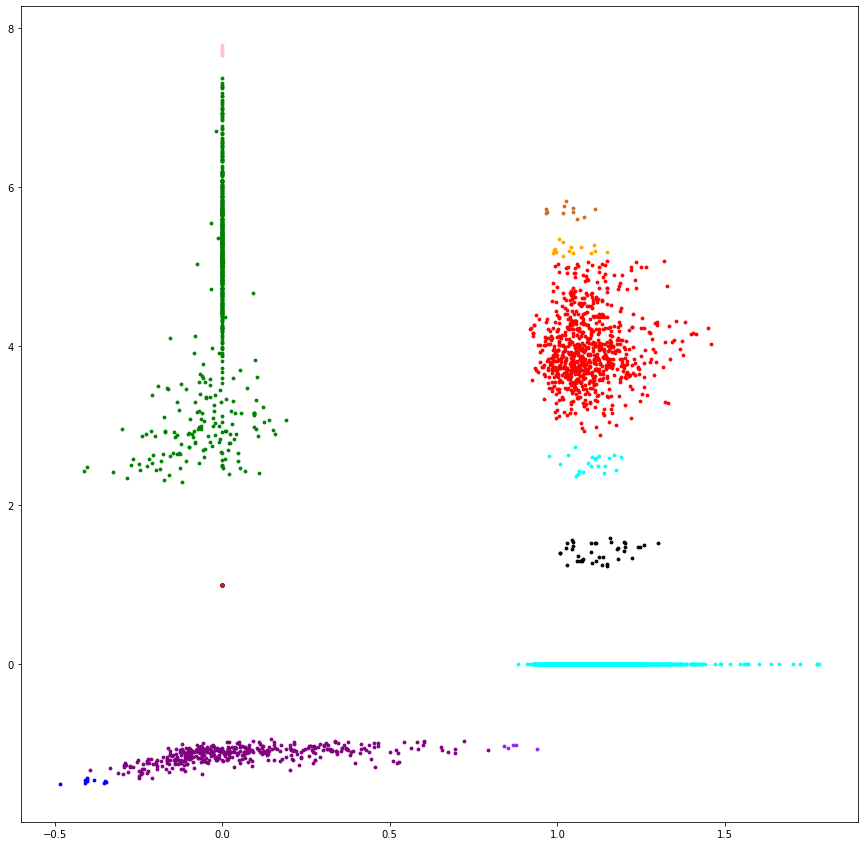

In [16]:
plt.gcf().set_size_inches(15,15)
plotClustering(roznice.T,grupowanieRoznic)

Następnie w celu zobrazowania całego zbioru punktów stosuję algorytm TSNE. Widać, że wykrył on kilka rozłącznych grup, które dodatkowo znacząco się różnią pod względem maksymalnej różnicy z regionów zewnętrznych i regionu środkowego.

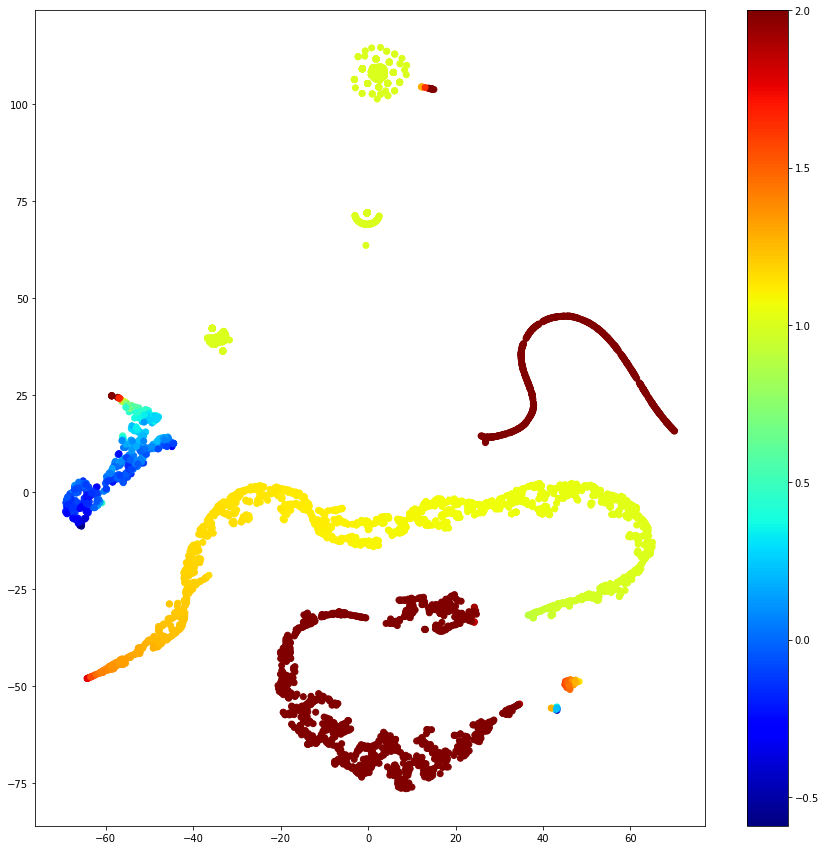

In [17]:
k2=np.clip(kolory,-2,2)
tsne=TSNE()
tsneWynik=tsne.fit_transform(results.T).T

plt.gcf().set_size_inches(15,15)
plt.scatter(tsneWynik[0],tsneWynik[1],c=k2,cmap="jet")
plt.colorbar()

Oprócz tego stosuję algorytm PCA. Radzi sobie on gorzej niż TSNE, między innymi w związku z zaszumieniem danych. 

In [18]:
pca=PCA(n_components=2)
pcaWynik=pca.fit_transform(results.T).T

plt.gcf().set_size_inches(15,15)
plt.scatter(pcaWynik[0],pcaWynik[1],c=k2,cmap="jet")
plt.colorbar()

## Grupowanie

Powyższe ilustracje wskazują, że należy użyć metody gęstościowej grupowania (dobry wynik TSNE, a słaby PCA), która poradzi sobie z szumem. Dlatego korzystam z algorytmu DBSCAN. Z parametrami:

|eps|min_samples|
|-|-|
|0.19|8|

Wykrywa on 10 grup, a około 4% punktów zalicza jako szum.

In [19]:
wynikDbscan=DBSCAN(eps=0.19, min_samples=8).fit_predict(results.T)

In [20]:
np.unique(wynikDbscan)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9])

In [21]:
punkty=results[:,np.where(wynikDbscan!=-1)].reshape((6,-1))

In [22]:
np.size(punkty,axis=1)/np.size(results,axis=1)

0.959541469993257

Po przeprowadzeniu grupowania przy pomocy DBSCAN można zilustrować punkty niebędącye szumem. Jak widać poszczególne grupy na wyniku TSNE są dobrze oddzielone, natomiast na wyniku PCA nie. Sugeruje to, że DBSCAN dobrze zgrupował punkty (tak jak mówi TSNE), ale dwa wymiary nie wystarczą aby je dobrze zareprezentować, stąd w wyniku PCA nakładają się punkty niebieskie, czerwone i pomarańczowe, a także jasno niebeskie i brązowe. Można więc przypuszczać, że grupy te są odległe względem siebie w jakimś trzecim wymiarze.

In [23]:
tsne=TSNE()
tsneWynik=tsne.fit_transform(punkty.T).T

k2=wynikDbscan[np.where(wynikDbscan!=-1)]
plt.gcf().set_size_inches(15,15)
plotClustering(tsneWynik.T,k2)

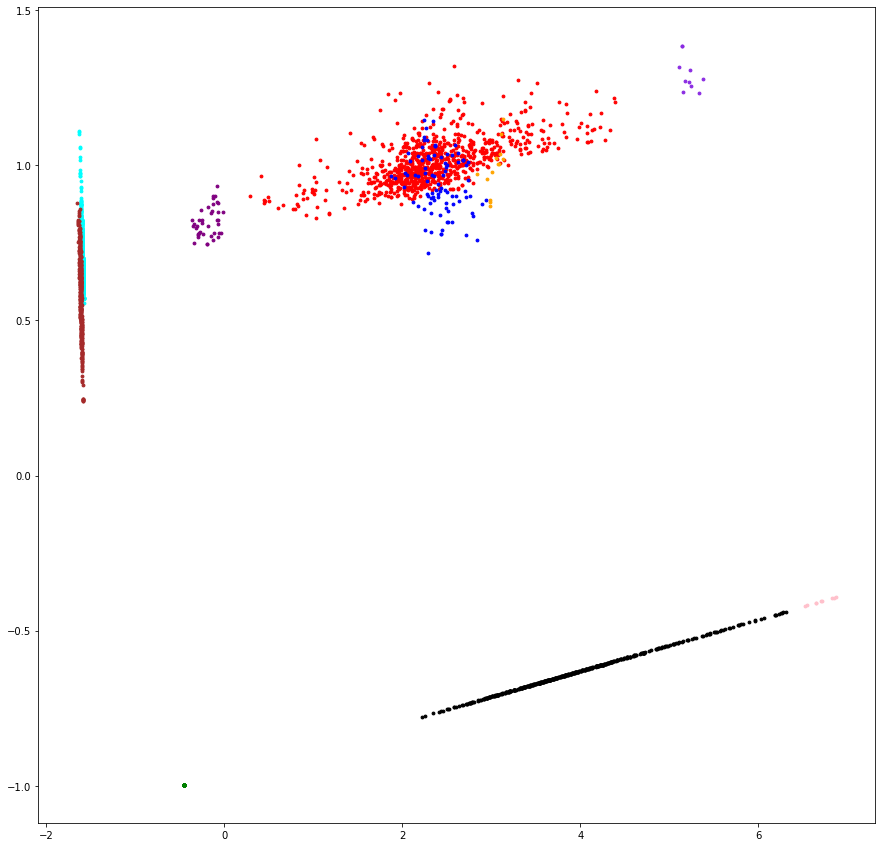

In [24]:
pca=PCA(n_components=2)
pcaWynik=pca.fit_transform(punkty.T).T

k2=wynikDbscan[np.where(wynikDbscan!=-1)]

plt.gcf().set_size_inches(15,15)
plotClustering(pcaWynik.T,k2)

## Wnioski

Udało zgrupować się sekwencje, na podstawie współczynnika F i względnej długości regionu. Oznacza to, że mogą istnieć pewne zależności między sekwencjami i ich właściwościami, a zapobieganiem mutacjom typu nonsens. W przyszłości należało by sprawdzić, jakim sekwencjom odpowiadają poszczególne grupy i co je łączy.